In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset, WeightedRandomSampler
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, roc_curve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# Load dataset
df = pd.read_csv('./dados/cleaned_dataset.csv')

In [4]:
# Drop unnecessary columns
df = df.drop(columns=['Id'])

In [5]:
# Split features and labels
X = df[['Score', 'Gender', 'Age', 'Assets', 'Products', 'Active']]
y = df['Churned']

In [6]:
# Normalize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1).to(device)  # Reshape y for compatibility

In [8]:
# Split data into training and testing sets
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(X_tensor, y_tensor, test_size=0.1, random_state=42)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

In [9]:
# Calculate class weights to handle imbalance
class_counts = np.bincount(y_train_tensor.cpu().numpy().flatten().astype(int))
class_weights = 1.0 / class_counts
sample_weights = [class_weights[int(y)] for y in y_train_tensor.cpu().numpy().flatten()]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [10]:
# Create DataLoader for training with weighted sampling
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)

In [11]:
# Split the dataset into training and validation sets for metric tracking
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

In [12]:
# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_subset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
print("Training and validation DataLoaders have been created.")

Training and validation DataLoaders have been created.


In [13]:
# Define neural network model
class BinaryClassificationModel(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size):
        super(BinaryClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, 1)
        self.gelu = nn.GELU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.gelu(self.fc1(x))
        x = self.gelu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [14]:
# Function to train and evaluate the model using cross-validation
def cross_val_model(hidden1_size, hidden2_size, learning_rate):
    hidden1_size = int(hidden1_size)
    hidden2_size = int(hidden2_size)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_accuracies = []

    for train_index, val_index in kf.split(X_tensor):
        X_train_fold = X_tensor[train_index]
        y_train_fold = y_tensor[train_index]
        X_val_fold = X_tensor[val_index]
        y_val_fold = y_tensor[val_index]

        # Create DataLoader for training fold
        train_dataset = TensorDataset(X_train_fold, y_train_fold)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        # Initialize the model, criterion, and optimizer
        model = BinaryClassificationModel(X_train_fold.shape[1], hidden1_size, hidden2_size).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Train the model
        model.train()
        for epoch in range(50):
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluate the model on the validation fold
        model.eval()
        with torch.no_grad():
            y_pred_probs = model(X_val_fold)
            y_pred = (y_pred_probs > 0.5).float()

        # Calculate accuracy for this fold
        acc = accuracy_score(y_val_fold.cpu().numpy(), y_pred.cpu().numpy())
        cv_accuracies.append(acc)

    # Return the average accuracy across folds
    return np.mean(cv_accuracies)



In [15]:
# Set the parameter bounds for Bayesian Optimization
param_bounds = {
    'hidden1_size': (32, 128),  # Number of neurons in the first hidden layer
    'hidden2_size': (16, 64),   # Number of neurons in the second hidden layer
    'learning_rate': (0.0001, 0.01)  # Learning rate for training
}

In [16]:
# Run Bayesian Optimization
optimizer = BayesianOptimization(f=cross_val_model, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=25)

|   iter    |  target   | hidden... | hidden... | learni... |
-------------------------------------------------------------
| 1         | 0.8129    | 67.96     | 61.63     | 0.007347  |
| 2         | 0.8339    | 89.47     | 23.49     | 0.001644  |
| 3         | 0.8119    | 37.58     | 57.58     | 0.006051  |
| 4         | 0.8139    | 99.97     | 16.99     | 0.009702  |
| 5         | 0.8329    | 111.9     | 26.19     | 0.0019    |
| 6         | 0.8079    | 111.8     | 26.15     | 0.006438  |
| 7         | 0.8459    | 47.44     | 35.15     | 0.0009565 |
| 8         | 0.8319    | 63.22     | 39.0      | 0.001514  |
| 9         | 0.8219    | 122.5     | 33.66     | 0.002291  |
| 10        | 0.8089    | 117.8     | 57.35     | 0.004191  |
| 11        | 0.8009    | 63.9      | 48.64     | 0.009634  |
| 12        | 0.8209    | 41.07     | 54.46     | 0.005997  |
| 13        | 0.8049    | 70.69     | 56.35     | 0.0076    |
| 14        | 0.8059    | 90.59     | 26.63     | 0.009764  |
| 15    

In [17]:
# Print the best parameters found
print("Best Parameters Found:")
print(optimizer.max)

Best Parameters Found:
{'target': 0.8458743718592965, 'params': {'hidden1_size': 47.43529628075367, 'hidden2_size': 35.15451534462412, 'learning_rate': 0.0009564998092699108}}


In [18]:
# Train the final model with the best parameters found and evaluate it
best_params = optimizer.max['params']
model = BinaryClassificationModel(X_tensor.shape[1], int(best_params['hidden1_size']), int(best_params['hidden2_size'])).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
criterion = nn.BCELoss()

In [19]:
# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [20]:
# Split the dataset into training and validation sets for metric tracking
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

In [21]:
# Train the model using the training set and evaluate using the validation set
model.train()
for epoch in range(50):
    # Training phase
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        total_train += labels.size(0)
        correct_train += ((outputs > 0.5).float() == labels).sum().item()

    train_losses.append(running_train_loss / total_train)
    train_accuracies.append(correct_train / total_train)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            running_val_loss += val_loss.item() * val_inputs.size(0)
            total_val += val_labels.size(0)
            correct_val += ((val_outputs > 0.5).float() == val_labels).sum().item()

    val_losses.append(running_val_loss / total_val)
    val_accuracies.append(correct_val / total_val)

    print(f"Epoch {epoch+1}/50, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

Epoch 1/50, Train Loss: 0.6166, Val Loss: 0.5852, Train Acc: 0.8067, Val Acc: 0.7611
Epoch 2/50, Train Loss: 0.5330, Val Loss: 0.5215, Train Acc: 0.8067, Val Acc: 0.7611
Epoch 3/50, Train Loss: 0.4640, Val Loss: 0.4886, Train Acc: 0.8067, Val Acc: 0.7611
Epoch 4/50, Train Loss: 0.4343, Val Loss: 0.4809, Train Acc: 0.8067, Val Acc: 0.7611
Epoch 5/50, Train Loss: 0.4233, Val Loss: 0.4731, Train Acc: 0.8136, Val Acc: 0.7611
Epoch 6/50, Train Loss: 0.4149, Val Loss: 0.4669, Train Acc: 0.8275, Val Acc: 0.7667
Epoch 7/50, Train Loss: 0.4085, Val Loss: 0.4630, Train Acc: 0.8401, Val Acc: 0.7667
Epoch 8/50, Train Loss: 0.4014, Val Loss: 0.4627, Train Acc: 0.8428, Val Acc: 0.7667
Epoch 9/50, Train Loss: 0.3964, Val Loss: 0.4565, Train Acc: 0.8428, Val Acc: 0.7722
Epoch 10/50, Train Loss: 0.3899, Val Loss: 0.4584, Train Acc: 0.8428, Val Acc: 0.7722
Epoch 11/50, Train Loss: 0.3844, Val Loss: 0.4583, Train Acc: 0.8442, Val Acc: 0.7722
Epoch 12/50, Train Loss: 0.3785, Val Loss: 0.4554, Train Acc: 0

In [22]:
# Final evaluation on the test set
model.eval()
with torch.no_grad():
    y_test_pred_probs = model(X_test_tensor)
    y_test_pred = (y_test_pred_probs > 0.5).float()

In [23]:
# Calculate test accuracy
test_accuracy = accuracy_score(y_test_tensor.cpu().numpy(), y_test_pred.cpu().numpy())
print("\nTest Accuracy:", test_accuracy)


Test Accuracy: 0.86


In [24]:
# Compute and display the confusion matrix
cnf_matrix = confusion_matrix(y_test_tensor.cpu().numpy(), y_test_pred.cpu().numpy())
cnf_table = pd.DataFrame(data=cnf_matrix, index=['Non-Churned', 'Churned'], columns=['Non_Churned(pred)', 'Churned(pred)'])
print("\nConfusion Matrix:")
print(cnf_table)


Confusion Matrix:
             Non_Churned(pred)  Churned(pred)
Non-Churned                 77              2
Churned                     12              9


In [25]:
# Print classification report with the zero_division parameter
print("\nClassification Report:")
print(classification_report(y_test_tensor.cpu().numpy(), y_test_pred.cpu().numpy(), target_names=['Non Churned', 'Churned'], zero_division=1))


Classification Report:
              precision    recall  f1-score   support

 Non Churned       0.87      0.97      0.92        79
     Churned       0.82      0.43      0.56        21

    accuracy                           0.86       100
   macro avg       0.84      0.70      0.74       100
weighted avg       0.86      0.86      0.84       100



In [26]:
# Print additional evaluation metrics
roc_auc = roc_auc_score(y_test_tensor.cpu().numpy(), y_test_pred_probs.cpu().numpy())
precision, recall, _ = precision_recall_curve(y_test_tensor.cpu().numpy(), y_test_pred_probs.cpu().numpy())
pr_auc = auc(recall, precision)

print(f"\nROC AUC Score: {roc_auc:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")


ROC AUC Score: 0.8107
Precision-Recall AUC: 0.6329


In [27]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_tensor.cpu().numpy(), y_test_pred_probs.cpu().numpy())
roc_auc = roc_auc_score(y_test_tensor.cpu().numpy(), y_test_pred_probs.cpu().numpy())

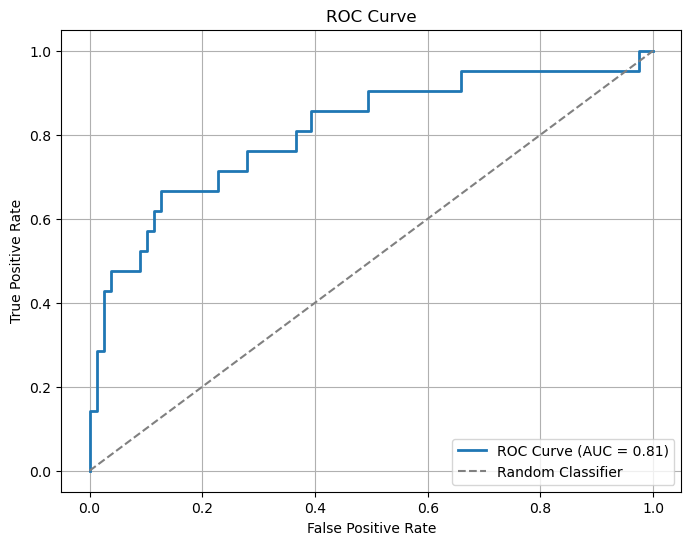

In [28]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

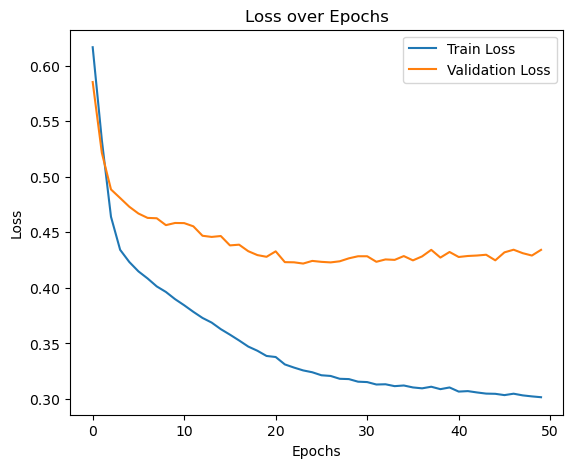

In [29]:
# Plot training and validation metrics
plt.figure(figsize=(14, 5))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


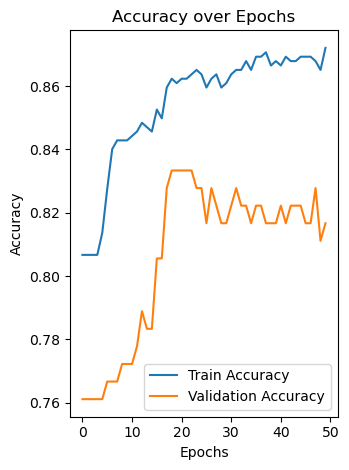

In [30]:
# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()